In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.metrics import roc_auc_score
from Vis import plot_loss, plot_roc
from Preprocessing import Preprocessing
from Preprocessing import Cols
import numpy as np
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from pandas import DataFrame
from pandas import Series
import pandas as pd
from keras.layers import Dropout
# pandas.set_option('max_columns',10)

Using TensorFlow backend.


In [2]:
pre = Preprocessing()
X, y = pre.load_data(time_gap=300)

prepared dataset contains: per_stud_dataset + per_action_dataset_summ


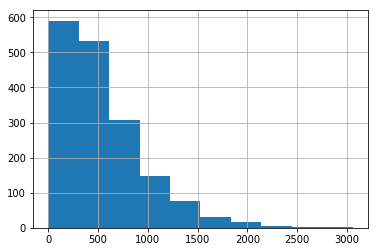

In [3]:
# number of actions for each student before summarization
pre.raw_dataset.groupby("ITEST_id").size().hist()

In [26]:
# having a sense about input dataset
raw_dataset = pre.raw_dataset.head()

In [27]:
index = raw_dataset.ITEST_id
raw_dataset = raw_dataset.drop("ITEST_id", axis=1)
raw_dataset.index = index

In [28]:
raw_dataset.head()

,AveCarelessness,AveCorrect,AveKnow,AveResBored,AveResConf,AveResEngcon,AveResFrust,AveResGaming,AveResOfftask,Ln,...,timeOver80,timeSinceSkill,timeTaken,totalFrAttempted,totalFrPastWrongCount,totalFrPercentPastWrong,totalFrSkillOpportunities,totalFrSkillOpportunitiesByScaffolding,totalFrTimeOnSkill,totalTimeByPercentCorrectForskill
ITEST_id,,,,,,,,,,,,,,,,,,,,,
922,0.085863,0.374477,0.169394,0.284355,0.125601,0.611127,0.137238,0.019325,0.219408,0.0360661,...,1,0.0,144.0,0,0,0.0,0,0.0,0.0,0.0
922,0.085863,0.374477,0.169394,0.284355,0.125601,0.611127,0.137238,0.019325,0.219408,0.0360661,...,0,0.0,13.0,1,0,0.0,1,0.0,0.0,0.0
922,0.085863,0.374477,0.169394,0.284355,0.125601,0.611127,0.137238,0.019325,0.219408,0.0360661,...,1,0.0,98.0,1,0,0.0,1,0.0,0.0,0.0
922,0.085863,0.374477,0.169394,0.284355,0.125601,0.611127,0.137238,0.019325,0.219408,0.0360661,...,1,0.0,81.0,1,0,0.0,1,0.0,0.0,0.0
922,0.085863,0.374477,0.169394,0.284355,0.125601,0.611127,0.137238,0.019325,0.219408,0.0360661,...,0,0.0,9.0,1,0,0.0,1,0.0,0.0,0.0


In [30]:
raw_dataset.head()

,AveCarelessness,AveCorrect,AveKnow,AveResBored,AveResConf,AveResEngcon,AveResFrust,AveResGaming,AveResOfftask,Ln,...,totalFrPastWrongCount,totalFrPercentPastWrong,totalFrSkillOpportunities,totalFrSkillOpportunitiesByScaffolding,totalFrTimeOnSkill,totalTimeByPercentCorrectForskill,ITEST_id,SchoolId,MCAS,isSTEM
66,0.085863,0.374477,0.169394,0.284355,0.125601,0.611127,0.137238,0.019325,0.219408,0.0360661,...,0,0.0,0,0.0,0.0,0.0,922,2,22,0
66,0.085863,0.374477,0.169394,0.284355,0.125601,0.611127,0.137238,0.019325,0.219408,0.0360661,...,0,0.0,1,0.0,0.0,0.0,922,2,22,0
66,0.085863,0.374477,0.169394,0.284355,0.125601,0.611127,0.137238,0.019325,0.219408,0.0360661,...,0,0.0,1,0.0,0.0,0.0,922,2,22,0
66,0.085863,0.374477,0.169394,0.284355,0.125601,0.611127,0.137238,0.019325,0.219408,0.0360661,...,0,0.0,1,0.0,0.0,0.0,922,2,22,0
66,0.085863,0.374477,0.169394,0.284355,0.125601,0.611127,0.137238,0.019325,0.219408,0.0360661,...,0,0.0,1,0.0,0.0,0.0,922,2,22,0


In [29]:
raw_dataset = pd.merge(raw_dataset, pre.label_dataset, right_on="ITEST_id", left_index=True)

In [32]:
[raw_dataset['ITEST_id'].values, raw_dataset['isSTEM'].values]

[array([922, 922, 922, 922, 922]), array([0, 0, 0, 0, 0])]

In [39]:
levels = [raw_dataset['ITEST_id'].values, raw_dataset['isSTEM'].values]
raw_dataset.index = pd.MultiIndex.from_arrays(levels, names=['ITEST_id', 'isSTEM'])
raw_dataset.drop(["ITEST_id", "isSTEM"] + Cols.excluded_cols, axis =1, inplace=True)

In [44]:
per_action_dataset = pre.per_action_dataset

index = per_action_dataset.ITEST_id
per_action_dataset = per_action_dataset.drop("ITEST_id", axis=1)
per_action_dataset.index = index

per_action_dataset = pd.merge(per_action_dataset, pre.label_dataset, right_on="ITEST_id", left_index=True)

per_action_dataset.drop(['assistmentId', 'problemId', 'assignmentId', 

In [43]:
pre.per_action_dataset.columns

Index(['assistmentId', 'past8BottomOut', 'scaffold', 'bottomHint', 'hintCount',
       'hint', 'frPast5WrongCount', 'problemId', 'frPast8HelpRequest',
       'stlHintUsed', 'timeOver80', 'frPast5HelpRequest', 'sumTimePerSkill',
       'frWorkingInSchool', 'totalFrSkillOpportunities', 'frPast8WrongCount',
       'RES_CONFUSED', 'totalFrSkillOpportunitiesByScaffolding',
       'timeGreater10SecAndNextActionRight', 'manywrong',
       'consecutiveErrorsInRow', 'frTimeTakenOnScaffolding', 'timeTaken',
       'totalFrPastWrongCount', 'RES_BORED', 'sumRight', 'responseIsChosen',
       'totalFrAttempted', 'frIsHelpRequestScaffolding', 'frIsHelpRequest',
       'assignmentId', 'responseIsFillIn', 'totalTimeByPercentCorrectForskill',
       'startTime', 'RES_FRUSTRATED', 'endTime', 'endsWithScaffolding',
       'helpAccessUnder2Sec', 'RES_OFFTASK', 'original', 'RES_CONCENTRATING',
       'correct', 'totalFrTimeOnSkill', 'hintTotal', 'attemptCount',
       'totalFrPercentPastWrong', 'timeGreate

In [40]:
raw_dataset

AveCarelessness  AveCorrect   AveKnow  AveResBored  \
ITEST_id isSTEM                                                       
922      0              0.085863    0.374477  0.169394     0.284355   
         0              0.085863    0.374477  0.169394     0.284355   
         0              0.085863    0.374477  0.169394     0.284355   
         0              0.085863    0.374477  0.169394     0.284355   
         0              0.085863    0.374477  0.169394     0.284355   

                 AveResConf  AveResEngcon  AveResFrust  AveResGaming  \
ITEST_id isSTEM                                                        
922      0         0.125601      0.611127     0.137238      0.019325   
         0         0.125601      0.611127     0.137238      0.019325   
         0         0.125601      0.611127     0.137238      0.019325   
         0         0.125601      0.611127     0.137238      0.019325   
         0         0.125601      0.611127     0.137238      0.019325   

                 AveResOfftask         Ln ...  timeTaken  totalFrAttempted  \
ITEST_id isSTEM                           ...                                
922      0            0.219408  0.0360661 ...      144.0                 0   
         0            0.219408  0.0360661 ...       13.0                 1   
         0            0.219408  0.0360661 ...       98.0                 1   
         0            0.219408  0.0360661 ...       81.0                 1   
         0            0.219408  0.0360661 ...        9.0                 1   

                 totalFrPastWrongCount  totalFrPercentPastWrong  \
ITEST_id isSTEM                                                   
922      0                           0                      0.0   
         0                           0                      0.0   
         0                           0                      0.0   
         0                           0                      0.0   
         0                           0                      0.0   

                 totalFrSkillOpportunities  \
ITEST_id isSTEM                              
922      0                               0   
         0                               1   
         0                               1   
         0                               1   
         0                               1   

                 totalFrSkillOpportunitiesByScaffolding  totalFrTimeOnSkill  \
ITEST_id isSTEM                                                               
922      0                                          0.0                 0.0   
         0                                          0.0                 0.0   
         0                                          0.0                 0.0   
         0                                          0.0                 0.0   
         0                                          0.0                 0.0   

                 totalTimeByPercentCorrectForskill  SchoolId MCAS  
ITEST_id isSTEM                                                    
922      0                                     0.0         2   22  
         0                                     0.0         2   22  
         0                                     0.0         2   22  
         0                                     0.0         2   22  
         0                                     0.0         2   22  

[5 rows x 78 columns]

In [7]:
try:
 index = [raw_dataset.ITEST_id, prepared_dataset.seq_ix]
 prepared_dataset = prepared_dataset.drop(["ITEST_id", "seq_ix"], axis=1)
except KeyError:
 print("Dataset contains only one index (ITEST_id)!")
 index = prepared_dataset.ITEST_id
 prepared_dataset = prepared_dataset.drop("ITEST_id", axis=1)

 prepared_dataset.index = index

try:
 y = prepared_dataset[Cols.label_col]
 y.index = prepared_dataset.index.get_level_values("ITEST_id")
 prepared_dataset = prepared_dataset.drop(Cols.label_col, axis=1)
except KeyError:
 y = None
 print("Warning! There is no label column in this setting!")

NameError: name 'prepared_dataset' is not defined